**Threshold Exceedance**

In [ ]:
import pandas as pd
import numpy as np

file = "PdM_telemetry - machine1 volt.csv"
data = pd.read_csv(file)

voltages = data['volt']

sizes = [50, 100, 150, 200]

results = {}

for size in sizes:
    subset = voltages[:size]
    threshold_95 = np.percentile(subset, 95)  # Compute 95th percentile
    exceed_count = (subset > threshold_95).sum()
    results[size] = {'95th Percentile': threshold_95, 'Exceed Count': exceed_count}

results_df = pd.DataFrame.from_dict(results, orient='index')

In [ ]:
results_df

,95th Percentile,Exceed Count
50,193.135814,3
100,195.654850,5
150,196.553942,8
200,197.157883,10


**Slope Calculation**



*   **Fourier Transformation**



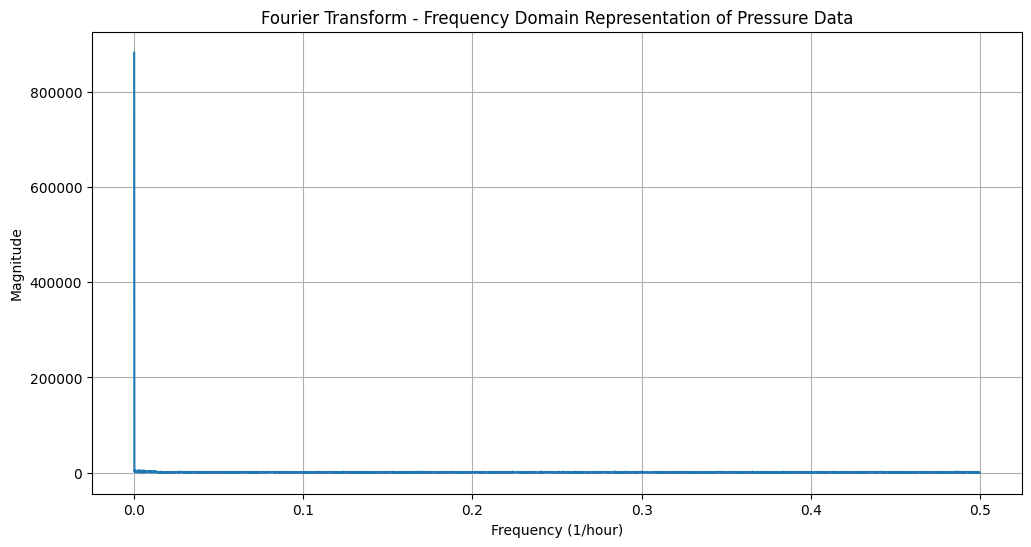

In [ ]:
# Fourier Transform to Discern Any Pattern

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import detrend

file_path = "/content/PdM_telemetry - machine1 pressure.csv"
df = pd.read_csv(file_path)

df['datetime'] = pd.to_datetime(df['datetime'])

pressure_values = df['pressure'].values
time_intervals = np.arange(len(pressure_values))

fft_values = fft(pressure_values)
frequencies = fftfreq(len(pressure_values), d=1)
magnitude = np.abs(fft_values)

plt.figure(figsize=(12, 6))
plt.plot(frequencies[:len(frequencies)//2], magnitude[:len(magnitude)//2])
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform - Frequency Domain Representation of Pressure Data')
plt.grid()
plt.show()

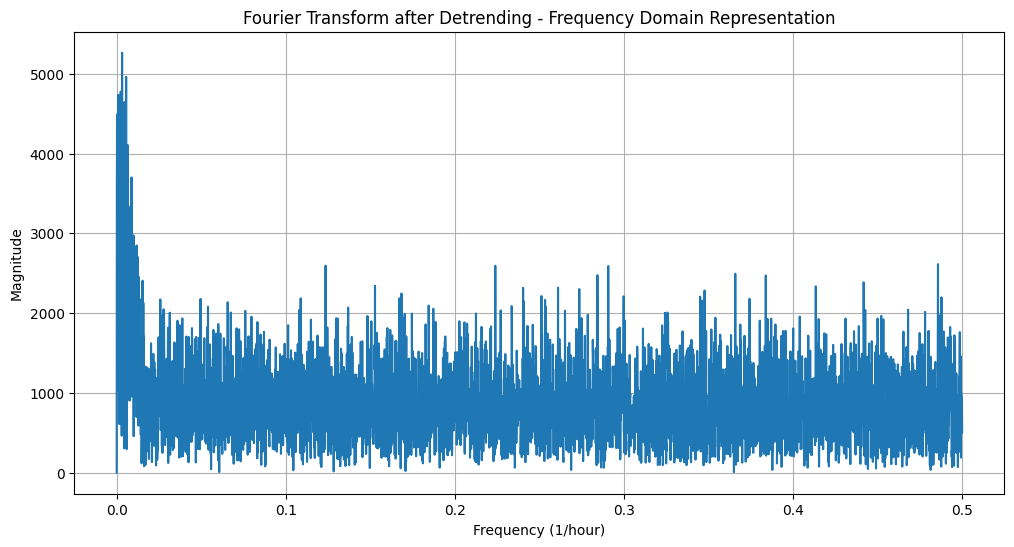

In [ ]:
# Detrend to Further Explore Pattern
detrended_pressure = detrend(pressure_values)

fft_values_detrended = fft(detrended_pressure)
magnitude_detrended = np.abs(fft_values_detrended)

plt.figure(figsize=(12, 6))
plt.plot(frequencies[:len(frequencies)//2], magnitude_detrended[:len(magnitude_detrended)//2])
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Magnitude')
plt.title('Fourier Transform after Detrending - Frequency Domain Representation')
plt.grid()
plt.show()

In [ ]:
# Identify the Dominant Frequency
positive_frequencies = frequencies[:len(frequencies)//2]
positive_magnitudes = magnitude_detrended[:len(magnitude_detrended)//2]

dominant_index = np.argmax(positive_magnitudes[1:]) + 1
dominant_frequency = positive_frequencies[dominant_index]
dominant_period = 1 / dominant_frequency

print(f"Dominant Frequency: {dominant_frequency:.4f} (1/hour)")
print(f"Corresponding Cycle Length: {dominant_period:.2f} hours")

Dominant Frequency: 0.0032 (1/hour)
Corresponding Cycle Length: 312.89 hours


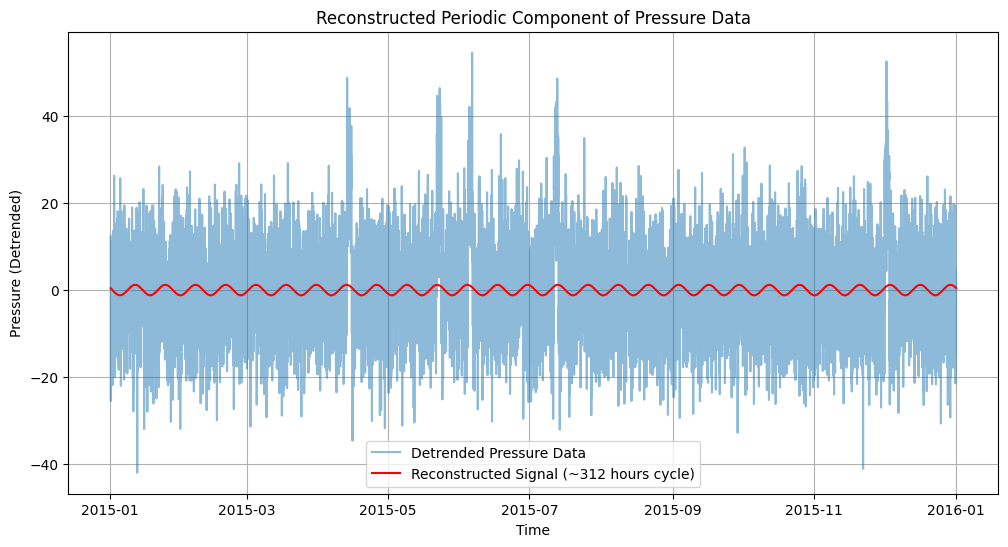

In [ ]:
dominant_fft = np.zeros_like(fft_values_detrended)
dominant_fft[dominant_index] = fft_values_detrended[dominant_index]
dominant_fft[-dominant_index] = fft_values_detrended[-dominant_index]

# Inverse Fourier Transform to reconstruct the signal
reconstructed_signal = np.real(np.fft.ifft(dominant_fft))

plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], detrended_pressure, label='Detrended Pressure Data', alpha=0.5)
plt.plot(df['datetime'], reconstructed_signal, label=f'Reconstructed Signal (~{int(dominant_period)} hours cycle)', color='red')
plt.xlabel('Time')
plt.ylabel('Pressure (Detrended)')
plt.title('Reconstructed Periodic Component of Pressure Data')
plt.legend()
plt.grid()
plt.show()

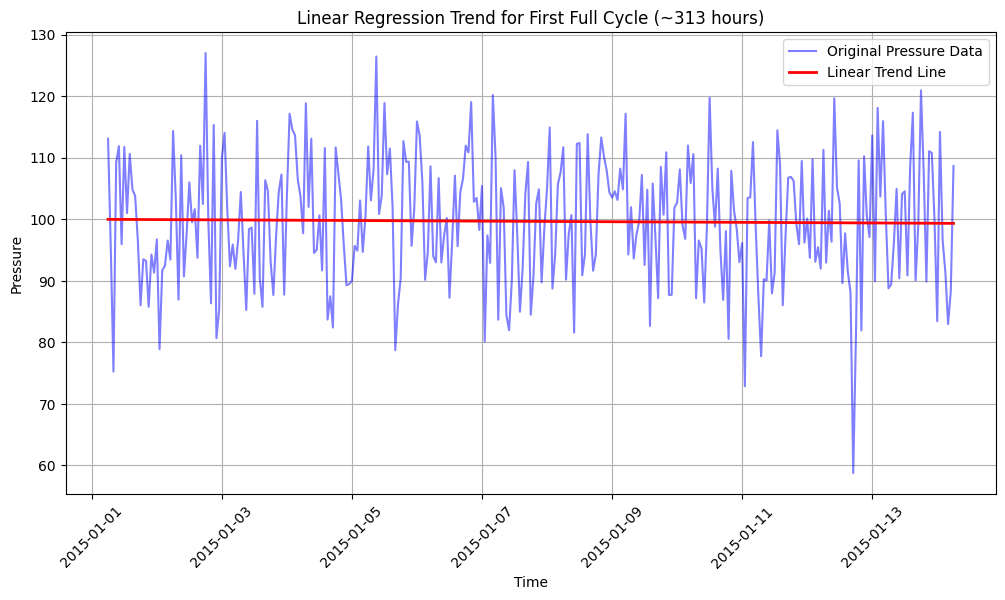

(-0.002076806044705754, 99.9824021197153)

In [ ]:
from sklearn.linear_model import LinearRegression

cycle_length = int(313)
df_cycle = df.iloc[:cycle_length]
time_numeric = np.arange(cycle_length).reshape(-1, 1)
pressure_cycle = df_cycle['pressure'].values

model = LinearRegression()
model.fit(time_numeric, pressure_cycle)

trend_line = model.predict(time_numeric)

plt.figure(figsize=(12, 6))
plt.plot(df_cycle['datetime'], df_cycle['pressure'], label='Original Pressure Data', color='blue', alpha=0.5)
plt.plot(df_cycle['datetime'], trend_line, label='Linear Trend Line', color='red', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.title(f'Linear Regression Trend for First Full Cycle (~{cycle_length} hours)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

slope = model.coef_[0]
intercept = model.intercept_
slope, intercept



*   **Adding Trend**



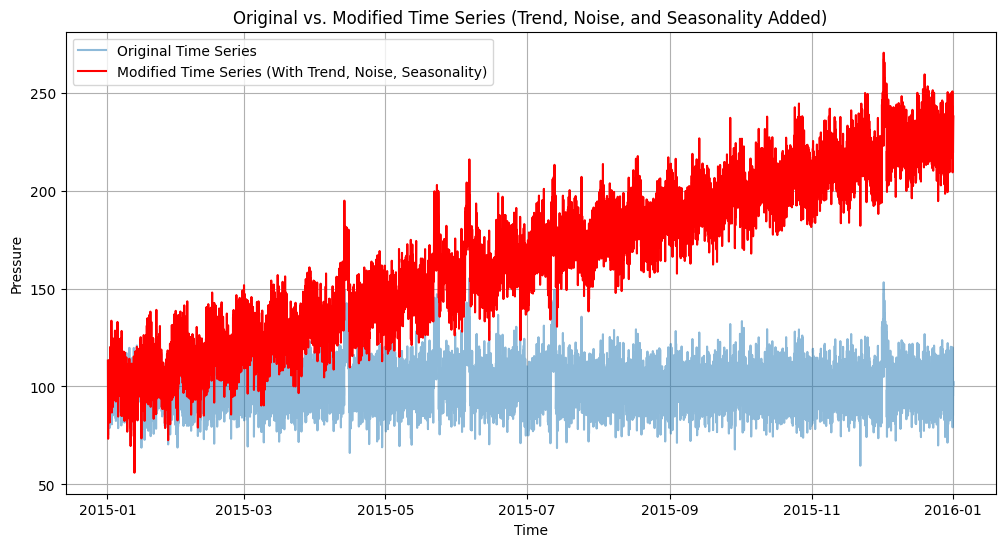

In [ ]:
file_path = "/content/PdM_telemetry - machine1 pressure.csv"
dataset = pd.read_csv(file_path)

dataset['time_marker'] = pd.to_datetime(dataset['datetime'])
dataset = dataset.sort_values('time_marker')

time_steps = np.arange(len(dataset))
sensor_readings = dataset['pressure'].values

# Parameters defined
growth_rate = 0.015
fluctuation_level = 1.8
cyclic_variation = 7
cycle_duration = 336

trend_effect = growth_rate * time_steps
random_variation = np.random.normal(0, fluctuation_level, len(dataset))
cyclic_effect = cyclic_variation * np.sin(2 * np.pi * time_steps / cycle_duration)
dataset['modified_sensor_readings'] = sensor_readings + trend_effect + random_variation + cyclic_effect

plt.figure(figsize=(12, 6))
plt.plot(dataset['time_marker'], dataset['pressure'], label='Original Time Series', alpha=0.5)
plt.plot(dataset['time_marker'], dataset['modified_sensor_readings'], label='Modified Time Series (With Trend, Noise, Seasonality)', color='red')
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.title('Original vs. Modified Time Series (Trend, Noise, and Seasonality Added)')
plt.legend()
plt.grid()
plt.show()

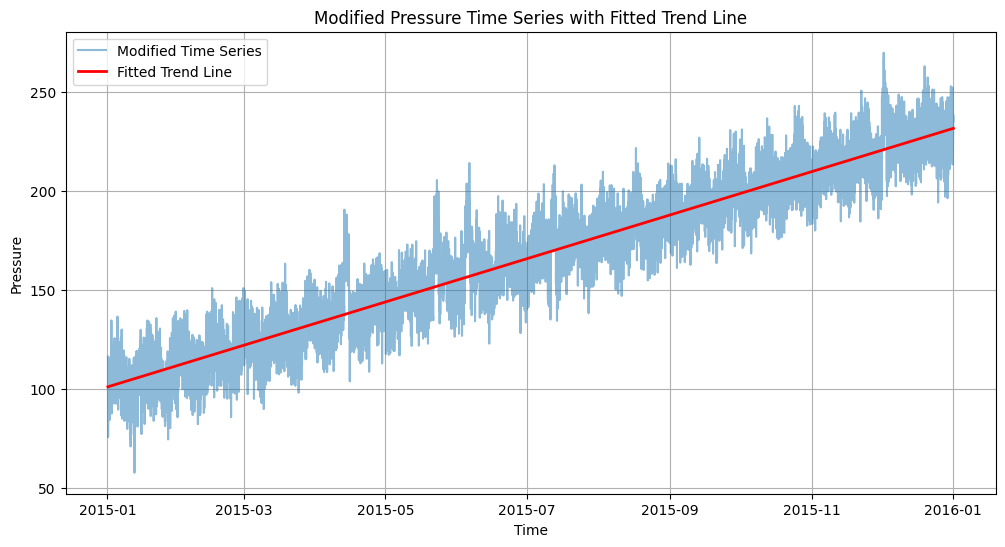

(0.014925813053946899, 101.01211350289223)

In [ ]:
# Slope for the entire dataset

time_steps_reshaped = time_steps.reshape(-1, 1)

trend_model = LinearRegression()
trend_model.fit(time_steps_reshaped, dataset['modified_sensor_readings'])

computed_slope = trend_model.coef_[0]
computed_intercept = trend_model.intercept_
fitted_trend = trend_model.predict(time_steps_reshaped)

plt.figure(figsize=(12, 6))
plt.plot(dataset['time_marker'], dataset['modified_sensor_readings'], label='Modified Time Series', alpha=0.5)
plt.plot(dataset['time_marker'], fitted_trend, label='Fitted Trend Line', color='red', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.title('Modified Pressure Time Series with Fitted Trend Line')
plt.legend()
plt.grid()
plt.show()

computed_slope, computed_intercept

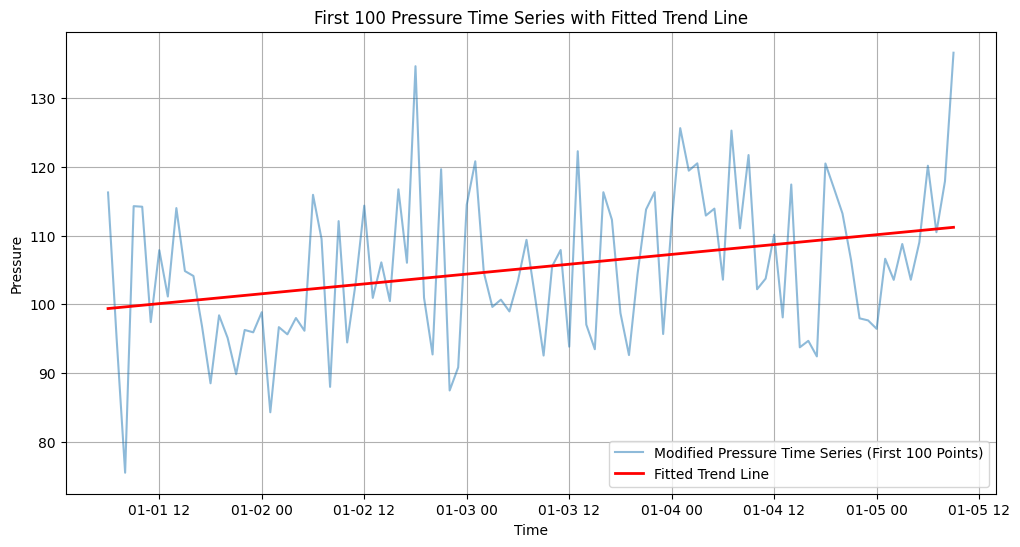

(0.11920612934777106, 99.38945546665937)

In [ ]:
# Slope for the first 100 points

subset_time_steps = time_steps[:100].reshape(-1, 1)
subset_sensor_readings = dataset['modified_sensor_readings'][:100].values

subset_trend_model = LinearRegression()
subset_trend_model.fit(subset_time_steps, subset_sensor_readings)

subset_computed_slope = subset_trend_model.coef_[0]
subset_computed_intercept = subset_trend_model.intercept_
subset_fitted_trend = subset_trend_model.predict(subset_time_steps)

plt.figure(figsize=(12, 6))
plt.plot(dataset['time_marker'][:100], subset_sensor_readings, label='Modified Pressure Time Series (First 100 Points)', alpha=0.5)
plt.plot(dataset['time_marker'][:100], subset_fitted_trend, label='Fitted Trend Line', color='red', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.title('First 100 Pressure Time Series with Fitted Trend Line')
plt.legend()
plt.grid()
plt.show()

subset_computed_slope, subset_computed_intercept



*   **Slope Between Each Time Step**



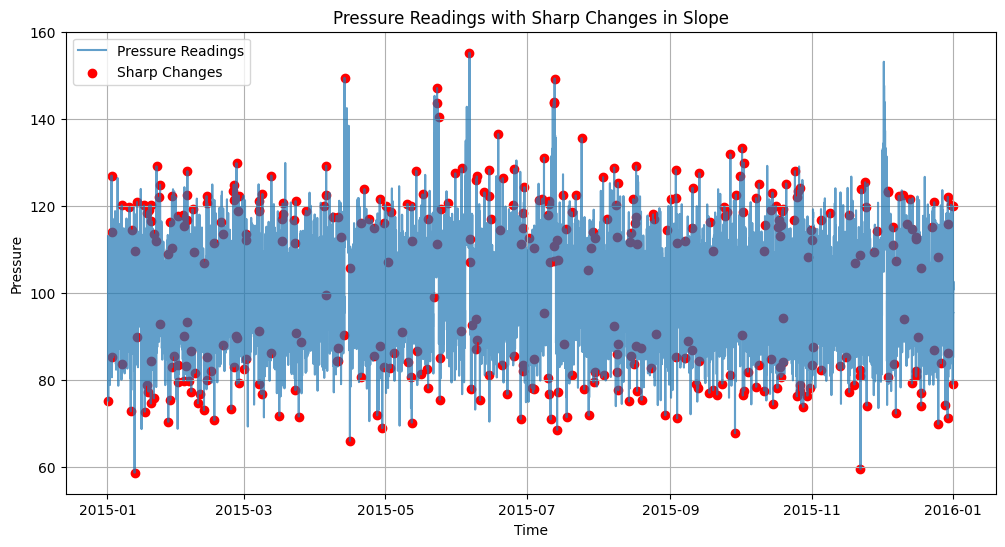

In [ ]:
dataset['time_marker'] = pd.to_datetime(dataset['datetime'])
dataset = dataset.sort_values('time_marker')
time_steps = np.arange(len(dataset))
sensor_readings = dataset['pressure'].values

dataset['slope'] = np.gradient(sensor_readings, time_steps)
dataset['slope_change'] = np.gradient(dataset['slope'], time_steps)

threshold = dataset['slope_change'].std() * 2  # Using 2 standard deviations as a threshold
sharp_changes = dataset[np.abs(dataset['slope_change']) > threshold]

plt.figure(figsize=(12, 6))
plt.plot(dataset['time_marker'], dataset['pressure'], label='Pressure Readings', alpha=0.7)
plt.scatter(sharp_changes['time_marker'], sharp_changes['pressure'], color='red', label='Sharp Changes', marker='o')
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.title('Pressure Readings with Sharp Changes in Slope')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Count the number of points that exceed the threshold
num_sharp_changes = sharp_changes.shape[0]
print(f"Number of sharp changes detected: {num_sharp_changes}")

Number of sharp changes detected: 402


<ipython-input-30-0ef6536f706e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sharp_changes['time_diff'] = sharp_changes['time_marker'].diff().dt.total_seconds() / 3600  # Convert to hours
<ipython-input-30-0ef6536f706e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sharp_changes['hour_of_day'] = sharp_changes['time_marker'].dt.hour
<ipython-input-30-0ef6536f706e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

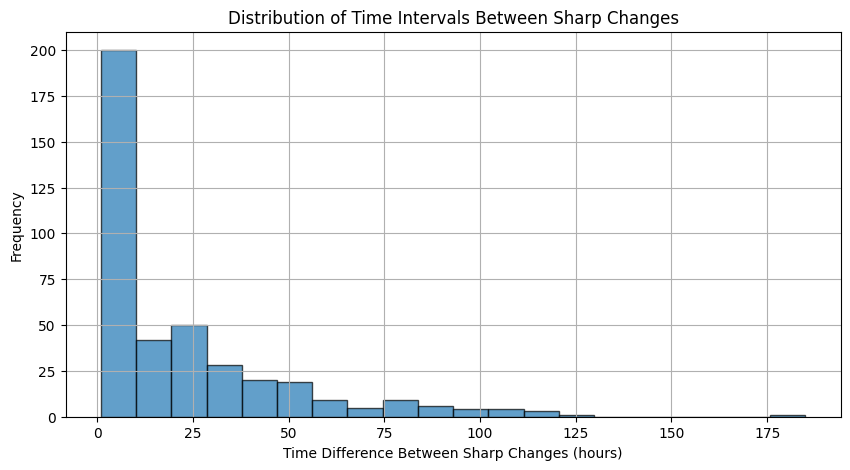

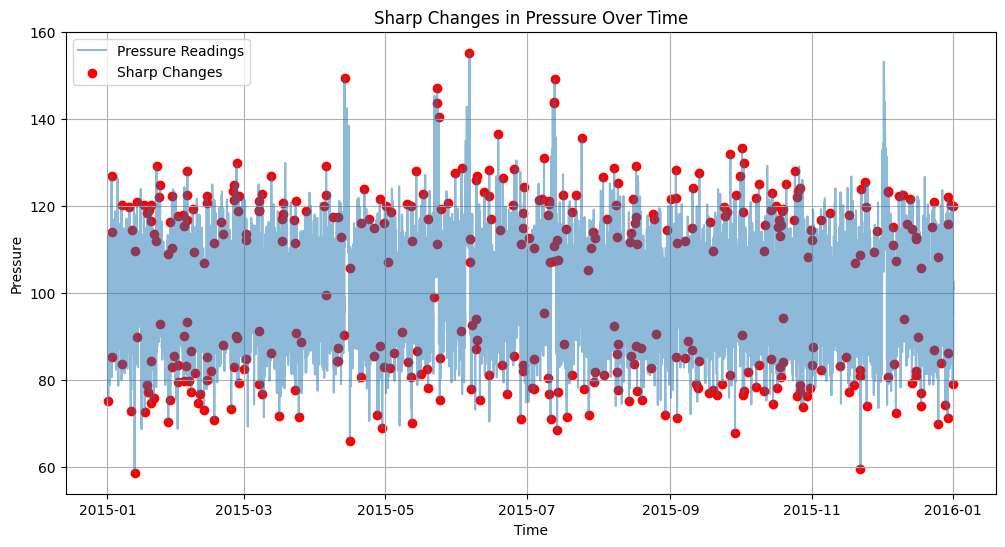

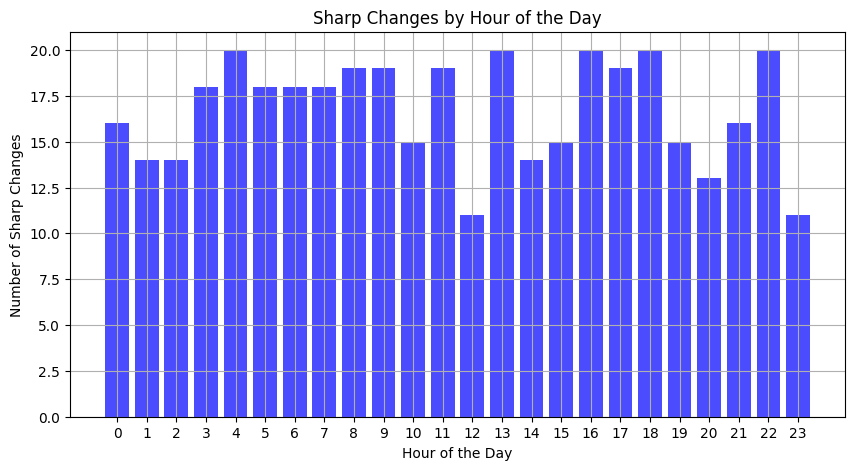

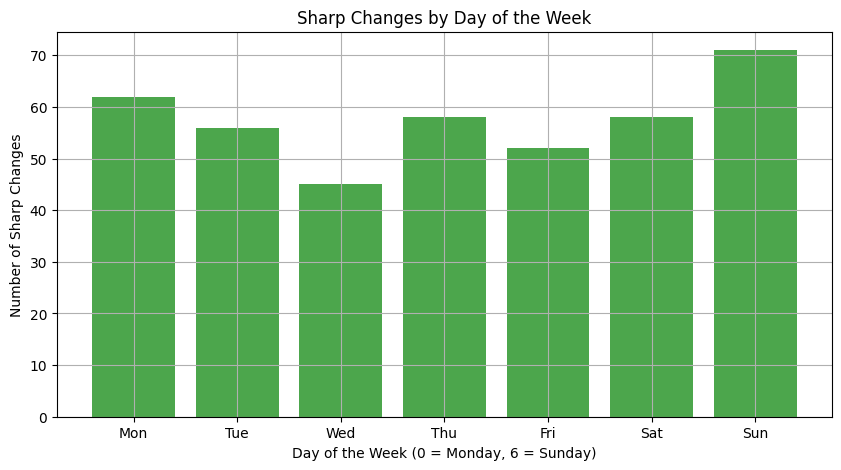

In [ ]:
sharp_changes['time_diff'] = sharp_changes['time_marker'].diff().dt.total_seconds() / 3600
time_diff_stats = sharp_changes['time_diff'].describe()
average_slope_change = sharp_changes['slope_change'].mean()

sharp_changes['hour_of_day'] = sharp_changes['time_marker'].dt.hour
hourly_pattern = sharp_changes.groupby('hour_of_day').size()

sharp_changes['day_of_week'] = sharp_changes['time_marker'].dt.dayofweek
weekly_pattern = sharp_changes.groupby('day_of_week').size()

# Plot hourly pattern of sharp changes
plt.figure(figsize=(10, 5))
plt.bar(hourly_pattern.index, hourly_pattern.values, color='blue', alpha=0.7)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Sharp Changes')
plt.title('Sharp Changes by Hour of the Day')
plt.xticks(range(24))
plt.grid()
plt.show()

# Plot weekly pattern of sharp changes
plt.figure(figsize=(10, 5))
plt.bar(weekly_pattern.index, weekly_pattern.values, color='green', alpha=0.7)
plt.xlabel('Day of the Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Number of Sharp Changes')
plt.title('Sharp Changes by Day of the Week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid()
plt.show()